*아핀변환을 이용한 이미지 교정*

+ *영수증 이미지가 정면에서 안찍히는 경우가 있으니.*
+ *Affine transform을 통해 이미지 픽셀값의 배치 변경*

  + *실제론, 2D 아핀변환에선 점 3개를 사용하여 수행*
  + *영수증은 보통 사각형이니, 점 4개 꼭지점에 대해서, 투시변환으로 수행 (실제 해당 ipynb)*

---

*아핀변환*

+ *선형변환은 아핀변환에 포함됨*

  + *선형변환 = 행렬곱을 통한 차원변환 과정*

    + *선형성 = 가산성과 동차성을 모두 만족하는 경우,*

  + *모든 선형변환은 아핀변환이나, 모든 아핀변환은 선형변환이진 않음*

+ *아핀변환 = 선형변환 + 이동(Translation)*

  + *차이: 원점 이동 (선형변환은 원점이 유지됨)*
  + *이동항이 0이면, 순수한 선형변환임*


In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### 1. Settings

In [11]:
import os
import sys

base_dir = "/content/gdrive/MyDrive/Workspace/Colab"
sys.path.append(base_dir)

src_dir = os.path.join(base_dir, "ocr")
%cd $src_dir

/content/gdrive/MyDrive/Workspace/Colab/ocr


In [12]:
!pip install -r requirements.txt > /dev/null

In [29]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()
for file_name, file_content in uploaded.items():
    print(f"File name: {file_name}")

image_files = list(uploaded.keys())

Saving padding_receipt1.png to padding_receipt1.png
File name: padding_receipt1.png


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [44]:
org_image = cv2.imread(image_files[0])

In [45]:
image = org_image.copy()

### 2. 아핀변환을 이용한 이미지 교정

*실제론, 투시(원근)변환..*

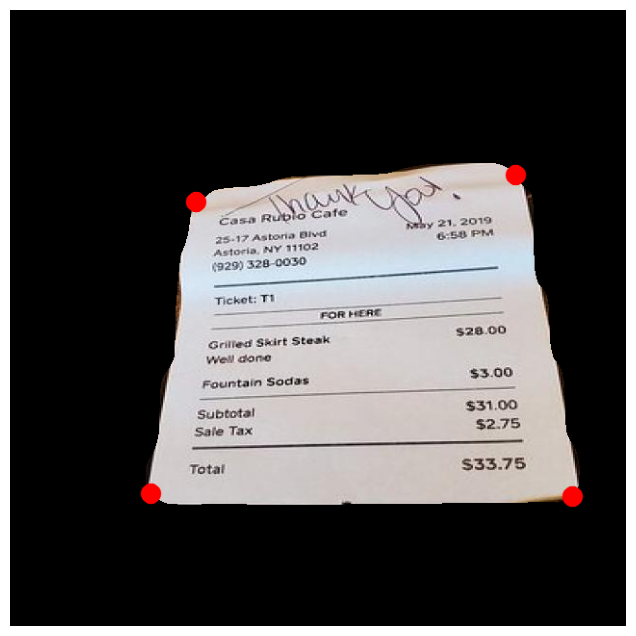

In [46]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

# 윤곽선 찾기
contours, _ = cv2.findContours(
    binary_image,
    cv2.RETR_EXTERNAL,       # 가장 바깥쪽 윤곽선만을 찾음
    cv2.CHAIN_APPROX_SIMPLE  # 윤곽선을 그릴 수 있는 최소한의 점만 저장
)
contour = max(contours, key=cv2.contourArea)

# 윤곽선 근사화
epsilon = 0.02 * cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

# 사각형의 각 꼭지점 찾기
if len(approx) == 4:
    points = approx.reshape(4, 2)

    def order_points(pts):
        """
        꼭지점 정렬
        (왼쪽 상단, 오른쪽 상단, 오른쪽 하단, 왼쪽 하단)
        """
        rect = np.zeros((4, 2), dtype="float32")

        s = pts.sum(axis=1)  # 가장 작은 값이 왼쪽 상단, 가장 큰 값이 오른쪽 하단
        diff = np.diff(pts, axis=1)  # 차이가 작은 값은 오른쪽 상단, 차이가 큰 값은 왼쪽 하단

        rect[0] = pts[np.argmin(s)]     # 왼쪽 상단
        rect[2] = pts[np.argmax(s)]     # 오른쪽 하단
        rect[1] = pts[np.argmin(diff)]  # 오른쪽 상단
        rect[3] = pts[np.argmax(diff)]  # 왼쪽 하단

        return rect

    rect = order_points(points)

    # circle 표시
    for point in rect:
        point = tuple(point.astype(int))
        cv2.circle(image, point, 10, (0, 0, 255), -1, cv2.LINE_AA)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

*꼭지점 찾기*

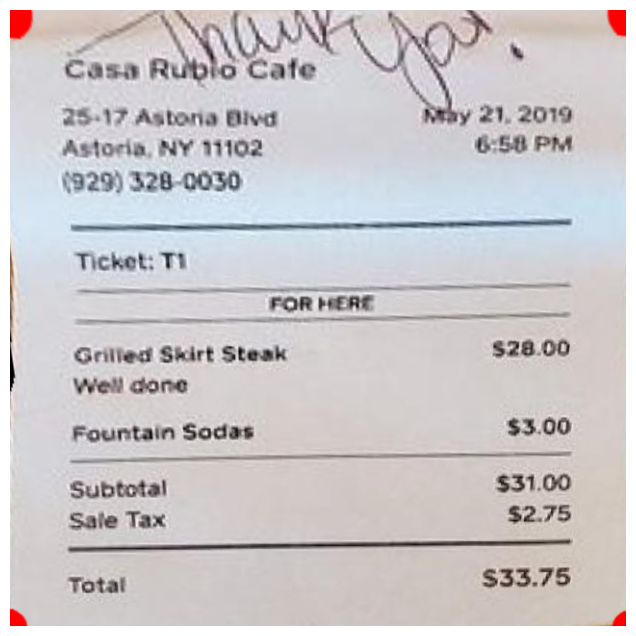

In [50]:
# 원본 이미지의 4개의 꼭지점
pts1 = np.float32(rect)

image_height, image_width = image.shape[:2]

# 목표 이미지의 좌표 설정 (정면)
pts2 = np.float32([
    [0, 0],                               # 왼쪽 상단
    [image_width - 1, 0],                 # 오른쪽 상단
    [image_width - 1, image_height - 1],  # 오른쪽 하단
    [0, image_height - 1]                 # 왼쪽 하단
])

# 투시(원근)변환 행렬 계산
M = cv2.getPerspectiveTransform(pts1, pts2)
result = cv2.warpPerspective(image, M, (image_width, image_height))

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

*투시변환이 기울어진 이미지를 정면으로 교정에 적절*